# Run statmorph on Becky's Virgo Cluster Spirals
https://statmorph.readthedocs.io/en/latest/notebooks/tutorial.html

Goals
* read in the images
* use photutils to run statmorph
* figure out how to use same segmentation map for gini segmap - don't redefine (may need to adapt statmorph code)


TODOs:
* fix headers of becky's images to add
  * pixel scale
  * wcs
  
* Keira - write out statmorph output as fits table

In [225]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.modeling.models import Sersic2D
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.stats import sigma_clipped_stats


from photutils.segmentation import detect_threshold, detect_sources
from photutils.morphology import gini
import time
import statmorph
import os
from astropy.io import fits
%matplotlib inline

homedir = os.getenv("HOME")

In [24]:
help(gini)

Help on function gini in module photutils.morphology.non_parametric:

gini(data)
    Calculate the `Gini coefficient
    <https://en.wikipedia.org/wiki/Gini_coefficient>`_ of a 2D array.
    
    The Gini coefficient is calculated using the prescription from `Lotz
    et al. 2004
    <https://ui.adsabs.harvard.edu/abs/2004AJ....128..163L/abstract>`_
    as:
    
    .. math::
        G = \frac{1}{\left | \bar{x} \right | n (n - 1)}
        \sum^{n}_{i} (2i - n - 1) \left | x_i \right |
    
    where :math:`\bar{x}` is the mean over all pixel values
    :math:`x_i`.
    
    The Gini coefficient is a way of measuring the inequality in a given
    set of values. In the context of galaxy morphology, it measures how
    the light of a galaxy image is distributed among its pixels.  A Gini
    coefficient value of 0 corresponds to a galaxy image with the light
    evenly distributed over all pixels while a Gini coefficient value of
    1 represents a galaxy image with all its light concentr

hi there


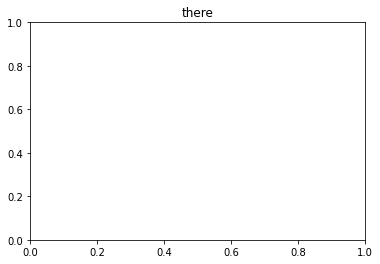

In [11]:
# aside on python classes

class demo():
    def __init__(self,printtext):
        print("hi "+str(printtext))
        self.name = printtext
    def make_figure(self):
        plt.figure()
        plt.title(self.name)
        
d1 = demo('there')
d1.make_figure()

In [2]:
!pwd

/Users/rfinn/github/havirgo/notebooks


In [12]:
# make a directory for saving output
#working_dir = homedir+"/siena/courses/AdvancedLab/KeiraFlaherty/statmorph-output"
#os.chdir(working_dir)
# saving this under Virgo, rather than in AdvancedLab


In [262]:
image_directory = homedir+'/research/Virgo/koopmann-images/Virgo/'
plots_directory = homedir+'/research/Virgo/koopmann-images/plots/'
os.chdir(plots_directory)

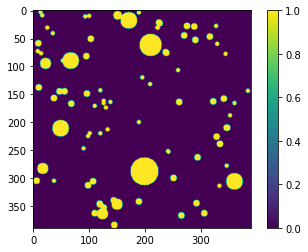

In [275]:
# define path to r and halpha images
im1_filename = image_directory+'n4178nrcsScal.fits'
im2_filename = image_directory+'n4178hacljc.fits'




im1_filename = image_directory+'n4413rclscjc.fits'
im2_filename = image_directory+'n4413hacljc.fits' 
mask_filename = image_directory+'n4413rmask.fits'

# read in the images and headers
image1, header1 = fits.getdata(im1_filename,header=True)
image2, header2 = fits.getdata(im2_filename,header=True)
mask = fits.getdata(mask_filename)
mask_bool = mask <1
plt.figure()
plt.imshow(mask_bool)
plt.colorbar()

median sky = 26.350650787353516


Text(0.5, 1.0, 'skyregion')

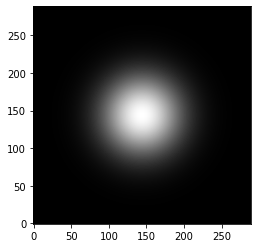

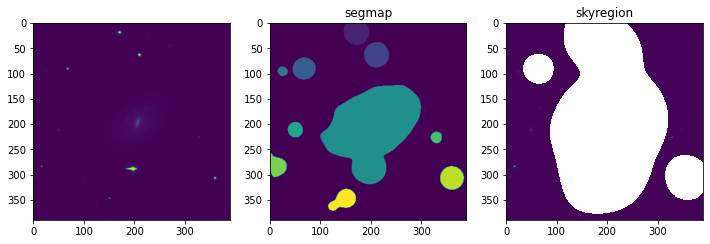

In [268]:
# add code to do background subtraction


# psf for making segmentation image when measuring the sky
kernel = Gaussian2DKernel(36)
kernel.normalize()  # make sure kernel adds up to 1
psfsky = kernel.array  # we only need the numpy array
plt.imshow(psfsky, origin='lower', cmap='gray')


threshold = detect_threshold(image1, 1.)
#print(threshold)

npixels = 15  # minimum number of connected pixels

# create a segmentation map
# this will contain all objects with npixels above threshold
convolved_image = convolve(image1, psfsky)
segmap_sky = detect_sources(convolved_image, threshold, npixels)


skyregion = np.ma.array(image1,mask=segmap_sky.data > 0)

mean,median,std = sigma_clipped_stats(skyregion,sigma=3.0,cenfunc=np.ma.median)
print(f"median sky = {median}")
# subtract background from image1
image1_minus_bkg = image1 - median

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(image1)
plt.subplot(1,3,2)
plt.imshow(segmap)
plt.title("segmap")

plt.subplot(1,3,3)
plt.imshow(skyregion)
plt.title("skyregion")
# get background



xcenter = 195, ycenter=195
segmentation value at center of image = 5


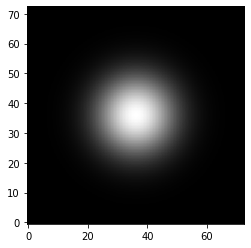

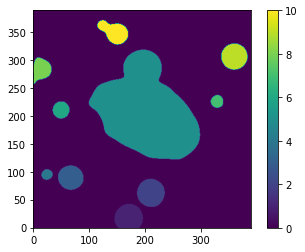

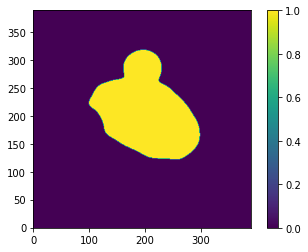

In [269]:
### MAKE SEGMENTATION MAP TO USE WITH STATMORPH


# psf for making segmentation image for galaxy
kernel = Gaussian2DKernel(9)
kernel.normalize()  # make sure kernel adds up to 1
psf = kernel.array  # we only need the numpy array
plt.imshow(psf, origin='lower', cmap='gray')


threshold = detect_threshold(image1, 1.2)
#print(threshold)

npixels = 15  # minimum number of connected pixels

# create a segmentation map
# this will contain all objects with npixels above threshold
convolved_image = convolve(image1, psf)
segmap = detect_sources(convolved_image, threshold, npixels)
#bkg1 = Background2D(skyregion,(9,9),filter_size=(3,3),bkg_estimator=MedianBackground())

plt.figure()
plt.imshow(segmap, origin='lower')#, cmap='gray')
plt.colorbar()

# estimate the position of the galaxy as the center of the x and y dimensions
# this assumes that the object is centered in the image
ymax, xmax = image1.shape
#print(xmax,ymax)
xc = xmax //2
yc = ymax //2
print(f"xcenter = {xc}, ycenter={yc}")

# get value of segmentation image at center
print(f"segmentation value at center of image = {segmap.data[yc,xc]}")
objid = segmap.data[yc,xc]


# create a new image with ones where segmap == objid and zeros otherwise
newsegmap = np.array(segmap.data == objid,'i')

# plot segmentation map - should be ones for galaxy pixels and zero otherwise
plt.figure()
plt.imshow(newsegmap, origin='lower')
plt.colorbar()


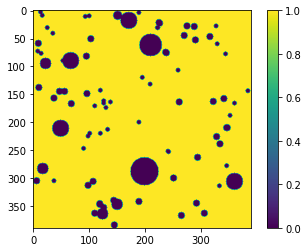

In [273]:
plt.imshow(mask)
plt.colorbar()

In [276]:
# running statmorph on r-band image
start = time.time()
source_morphs = statmorph.source_morphology(
    image1_minus_bkg, newsegmap, mask=mask_bool,gain=1)
print('Time: %g s.' % (time.time() - start))

Time: 1.76404 s.


In [ ]:
morph = source_morphs[0]

/Users/rfinn/research/Virgo/koopmann-images/plots/n4178nrcsScal-statmorph.pdf


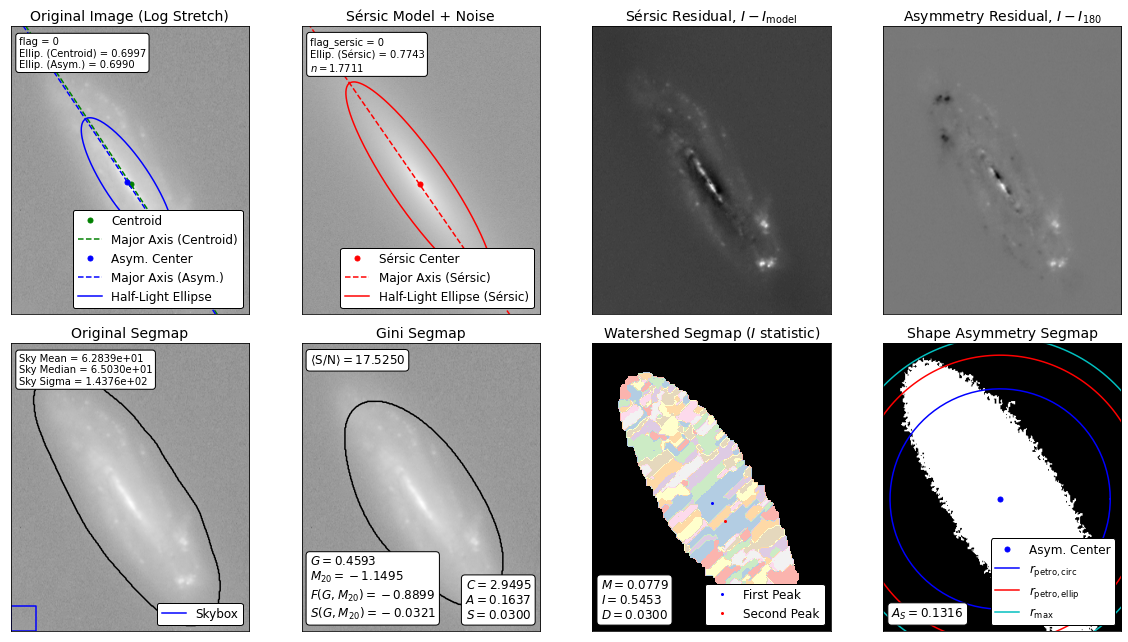

In [261]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)
im1name = os.path.basename(im1_filename)
outfile = os.path.join(plots_directory,im1name.replace('.fits','-statmorph.pdf'))
print(outfile)
plt.savefig(outfile)

Time: 6.08892 s.
/Users/rfinn/siena/courses/AdvancedLab/KeiraFlaherty/statmorph-output/n4178hacljc-statmorph.pdf


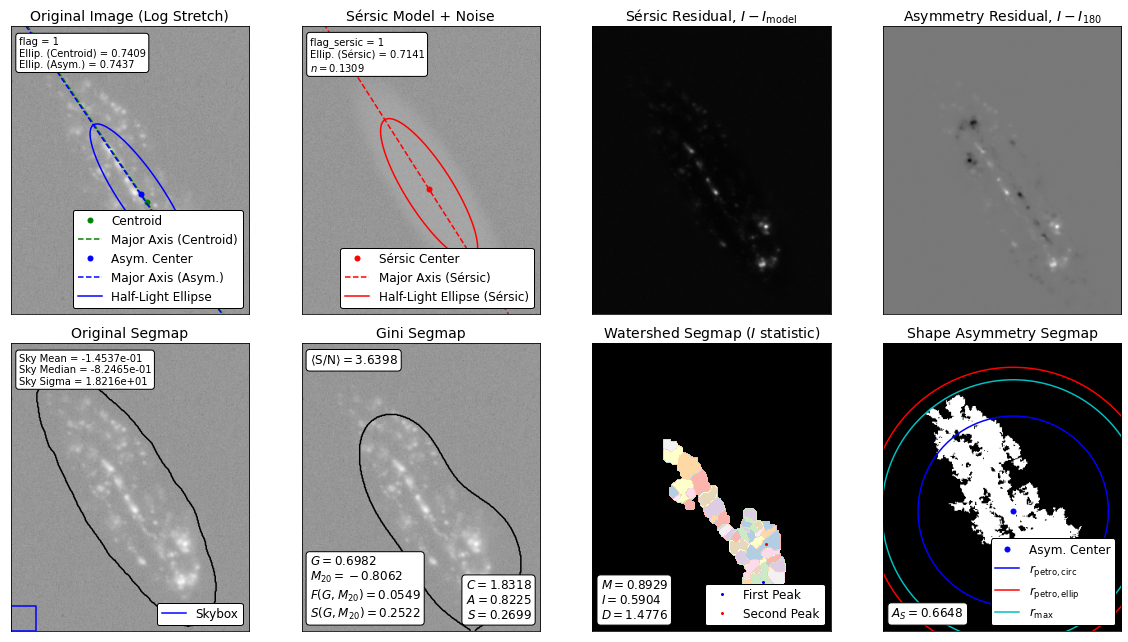

In [149]:
# running statmorph on r-band image
start = time.time()
source_morphs2 = statmorph.source_morphology(
    image2, newsegmap, gain=1, segmap_overlap_ratio=.8)
print('Time: %g s.' % (time.time() - start))

morph2 = source_morphs2[0]


fig = make_figure(morph2)
im2name = os.path.basename(im2_filename)
outfile = os.path.join(working_dir,im2name.replace('.fits','-statmorph.pdf'))
print(outfile)
plt.savefig(outfile)

In [146]:
del morph2.gini
morph2._segmap_gini = np.array(morph2._segmap.data == 1)
print(morph2.gini)

0.6963839423948783


In [186]:
class mySourceMorphology(statmorph.SourceMorphology):
    @lazyproperty
    def gini2(self):
        print("gini before new calc = ",self.gini)
        print("calculating gini2\n")
        self._segmap_gini = np.array(morph2._segmap.data == 1)
        image = self._cutout_stamp_maskzeroed.flatten()
        segmap = self._segmap_gini.flatten()

        sorted_pixelvals = np.sort(np.abs(image[segmap]))
        n = len(sorted_pixelvals)
        if n <= 1 or np.sum(sorted_pixelvals) == 0:
            warnings.warn('[gini] Not enough data for Gini calculation.',
                          AstropyUserWarning)
            self.flag = 2
            return -99.0  # invalid

        indices = np.arange(1, n+1)  # start at i=1
        gini2 = (np.sum((2*indices-n-1) * sorted_pixelvals) /
                (float(n-1) * np.sum(sorted_pixelvals)))
        print(gini2)
        return gini2

In [171]:
# running statmorph on r-band image
start = time.time()
#source_morphs2 = source_morphology(
    



morph2 = statmorph.SourceMorphology(image2, newsegmap, 1,gain=1, segmap_overlap_ratio=.8)
#morph2 = source_morphs2[0]
print('Time: %g s.' % (time.time() - start))


Time: 5.26933 s.


In [172]:
print(morph2.gini)

0.6982333992969173


Time: 5.14986 s.
gini before new calc =  0.6982333992969173
calculating gini2

0.6963839423948783
0.6963839423948783


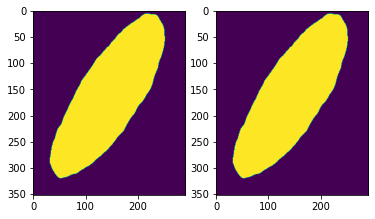

In [188]:
# running statmorph on r-band image
start = time.time()
#source_morphs2 = source_morphology(
    
morph3 = mySourceMorphology(image2, newsegmap, 1,gain=1)
#morph2 = source_morphs2[0]
print('Time: %g s.' % (time.time() - start))
print(morph3.gini2)


plt.figure()
plt.subplot(1,2,1)
plt.imshow(morph3._segmap)
plt.subplot(1,2,2)
plt.imshow(morph3._segmap_gini)

In [177]:
morph3.gini2

0.6963839423948783

In [206]:
%run ~/github/havirgo/python/myStatmorph.py

<Figure size 432x288 with 0 Axes>

calculating gini2



Time: 5227.78 s.
0.6963839423948783


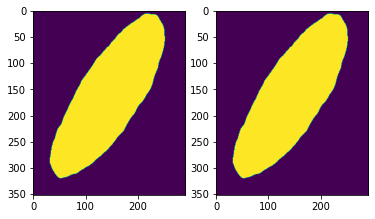

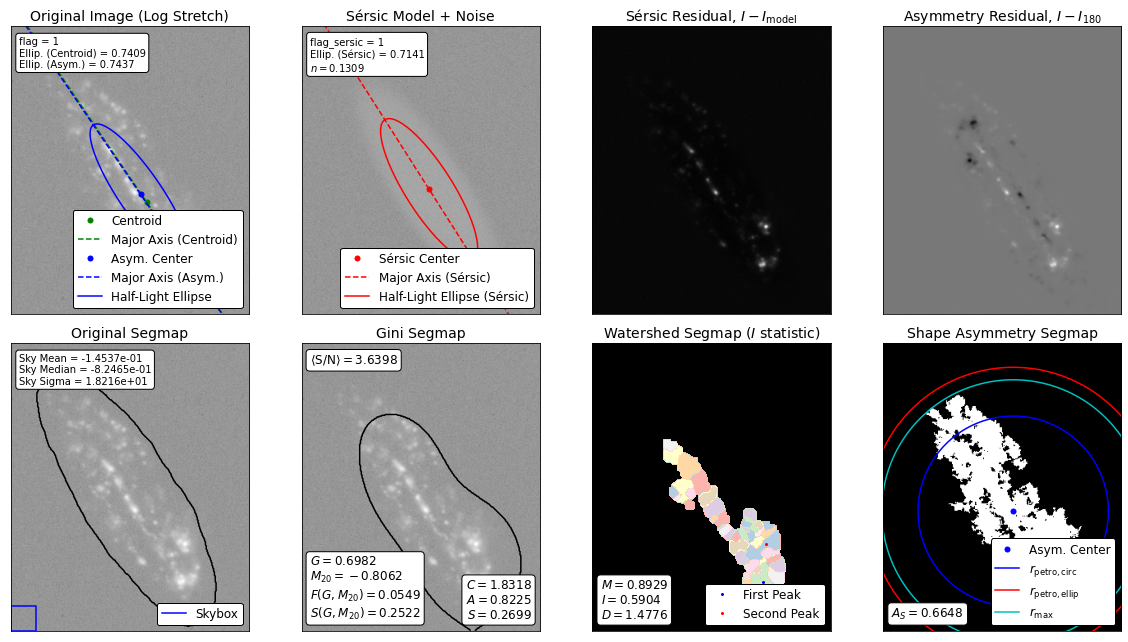

In [207]:
morph4 = myStatmorph(image2, newsegmap, 1,gain=1)
#morph2 = source_morphs2[0]
print('Time: %g s.' % (time.time() - start))
print(morph4.gini)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(morph4._segmap)
plt.subplot(1,2,2)
plt.imshow(morph4._segmap_gini)

fig = make_figure(morph3)

In [192]:
morph3.gini

0.6982333992969173

In [66]:
from photutils.segmentation import SegmentationImage
t = SegmentationImage(newsegmap)
t.shape
s1 = statmorph.SourceMorphology(image2,t,1,gain=1)

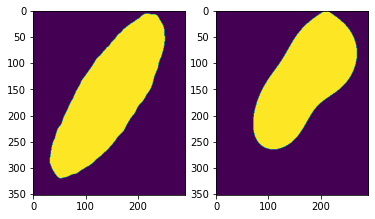

In [70]:
s1.gini
plt.figure()
plt.subplot(1,2,1)
plt.imshow(s1._segmap)
plt.subplot(1,2,2)
plt.imshow(s1._segmap_gini)

In [76]:
s1._segmap_gini = s1._segmap
s1['gini']
#print(s1.gini)

0.6982333992969173

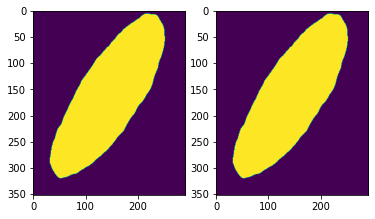

In [77]:
s1.gini
plt.figure()
plt.subplot(1,2,1)
plt.imshow(s1._segmap)
plt.subplot(1,2,2)
plt.imshow(s1._segmap_gini)

In [25]:
%run ~/github/halphagui/photwrapper.py

so sorry, but no images were loaded
try e = ellipse(imagename) to start
--- 0.0026199817657470703 seconds ---


<Figure size 432x288 with 0 Axes>

In [26]:
e = ellipse(im1_filename,image2=im2_filename)

Changed DATE-OBS from '23/ 3/1987        ' to '1987-03-23''. [astropy.wcs.wcs]


UnitConversionError: '' (dimensionless) and 'arcsec' (angle) are not convertible

In [27]:
# updating header
himage, hheader = fits.getdata(im1_filename,header=True)

In [28]:
ra = hheader['RA']

In [29]:
ra

'12:12:07.00'

In [30]:
from astropy import coordinates as coord
from astropy import units as u
from astropy.coordinates import SkyCoord

In [31]:
RA = coord.Angle(hheader['RA'],unit=u.hour)
DEC = coord.Angle(hheader['DEC'],unit=u.degree)

In [32]:
EQUINOX = '1950.0'

c = SkyCoord(ra=RA.deg*u.degree,dec=DEC.degree*u.degree,frame='fk5',equinox='J'+str(EQUINOX))
#print 'original coords = ',c
c2000 = c.transform_to(coord.FK5(equinox='J2000.0'))

In [33]:
c2000

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (183.66654854, 10.65653138)>

In [35]:
c2000.ra

<Longitude 183.66654854 deg>

In [36]:
# 183.193609, 10.866029	

In [37]:
c

<SkyCoord (FK5: equinox=J1950.000): (ra, dec) in deg
    (183.02916667, 10.93444444)>

In [38]:
c.ra

<Longitude 183.02916667 deg>

In [39]:
im1_filename

'/Users/rfinn/research/Virgo/koopmann-images/n4178nrcsScal.fits'

In [78]:
from astropy.utils import lazyproperty

In [79]:
help(lazyproperty)

Help on class lazyproperty in module astropy.utils.decorators:

class lazyproperty(builtins.property)
 |  lazyproperty(fget, fset=None, fdel=None, doc=None)
 |  
 |  Works similarly to property(), but computes the value only once.
 |  
 |  This essentially memorizes the value of the property by storing the result
 |  of its computation in the ``__dict__`` of the object instance.  This is
 |  useful for computing the value of some property that should otherwise be
 |  invariant.  For example::
 |  
 |      >>> class LazyTest:
 |      ...     @lazyproperty
 |      ...     def complicated_property(self):
 |      ...         print('Computing the value for complicated_property...')
 |      ...         return 42
 |      ...
 |      >>> lt = LazyTest()
 |      >>> lt.complicated_property
 |      Computing the value for complicated_property...
 |      42
 |      >>> lt.complicated_property
 |      42
 |  
 |  As the example shows, the second time ``complicated_property`` is accessed,
 |  the `

In [201]:
class tester():
    @lazyproperty
    def testproperty(self):
        print('returning value')
        return 10
    
    

    
class mytester(tester):
    @lazyproperty
    def testproperty(self):
        print('returning value')
        return 11

In [202]:
myt = mytester()

In [203]:
myt.testproperty

returning value


11

In [112]:
%run ~/github/statmorph/statmorph/statmorph.py

<Figure size 432x288 with 0 Axes>

In [113]:
# running statmorph on r-band image
start = time.time()
source_morphs2 = source_morphology(
    image2, newsegmap, gain=1, segmap_overlap_ratio=.8)
print('Time: %g s.' % (time.time() - start))

morph2 = source_morphs2[0]


#fig = make_figure(morph2)
#im2name = os.path.basename(im2_filename)
#outfile = os.path.join(working_dir,im2name.replace('.fits','-statmorph.pdf'))
#print(outfile)
#plt.savefig(outfile)

Time: 6.03862 s.


In [123]:
morph2

In [114]:
morph2.gini

0.20409316064995212

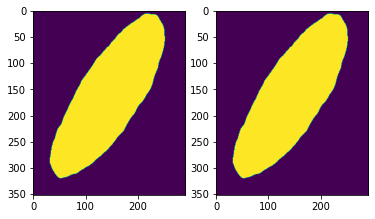

In [115]:
s1.gini
plt.figure()
plt.subplot(1,2,1)
plt.imshow(morph2._segmap)
plt.subplot(1,2,2)
plt.imshow(morph2._segmap_gini)

In [103]:
morph2._segmap_gini

array(0, dtype=int32)

In [116]:
morph2.gini

0.20409316064995212

In [120]:
morph2.asymmetry

0.8224528535403788

In [121]:
morph2.r20

43.29937078208806

In [122]:

fig = make_figure(morph2)
im2name = os.path.basename(im2_filename)
outfile = os.path.join(working_dir,im2name.replace('.fits','-statmorph.fixedsegmap.pdf'))
print(outfile)
plt.savefig(outfile)

TypeError: Input must be of type SourceMorphology.

In [124]:
isinstance(morph2,SourceMorphology)

True

# TODO

* need to find out how to delete an instance of a lazyproperty

* delete gini
* set self._segmap_gini to self._segmap
* then recalculate gini

* what about CAS parameters?